In [103]:
# Packages
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
# Paths
main_path = r"."
raw_path = r"{}/00_Raw".format(main_path)
code_path = r"{}/01_Code".format(main_path)
data_path = r"{}/02_Data".format(main_path)
output_path = r"{}/03_Output".format(main_path)
# Specifying plotting information
dict_examples = {
    "ferrari": {
        "file": r"{}/ferrari/{}".format(raw_path, "f_austria.wav"),
        "color": "red"
    },
    "mercedes": {
        "file": r"{}/mercedes/{}".format(raw_path, "m_australia.wav"),
        "color": "silver"
    }
}

print(raw_path)

./00_Raw


In [104]:
%pwd

import glob
print(glob.glob("./00_Raw/*"))

['./00_Raw/mercedes', './00_Raw/ferrari']


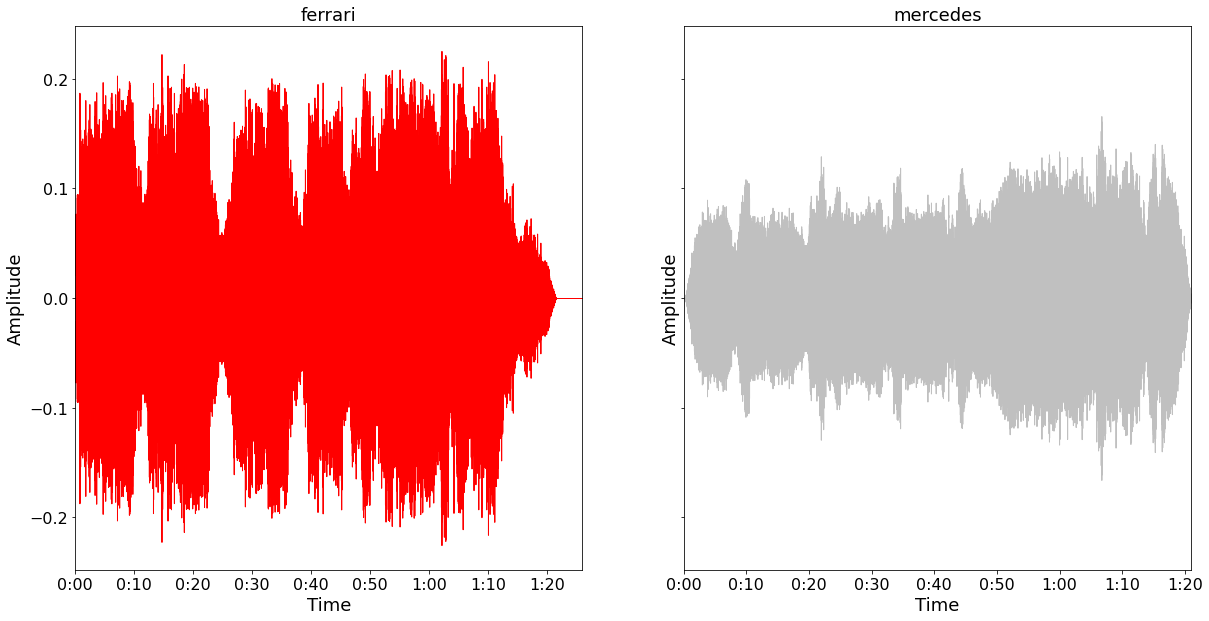

In [105]:
# Time domain Plot
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 10))
SR = 22_050
axs = axs.ravel()
for num, team in enumerate(dict_examples):
    signal, sr = librosa.load(dict_examples[team]["file"], sr=SR)
    dict_examples[team]["signal"] = signal
    librosa.display.waveplot(signal, sr=sr, ax=axs[num],
                             color=dict_examples[team]["color"])
    axs[num].set_title(team, {"fontsize":18})
    axs[num].tick_params(axis="both", labelsize=16)
    axs[num].set_ylabel("Amplitude", fontsize=18)
    axs[num].set_xlabel("Time", fontsize=18)
fig.savefig("{}/waveplot.png".format(output_path),
            bbox_inches="tight")

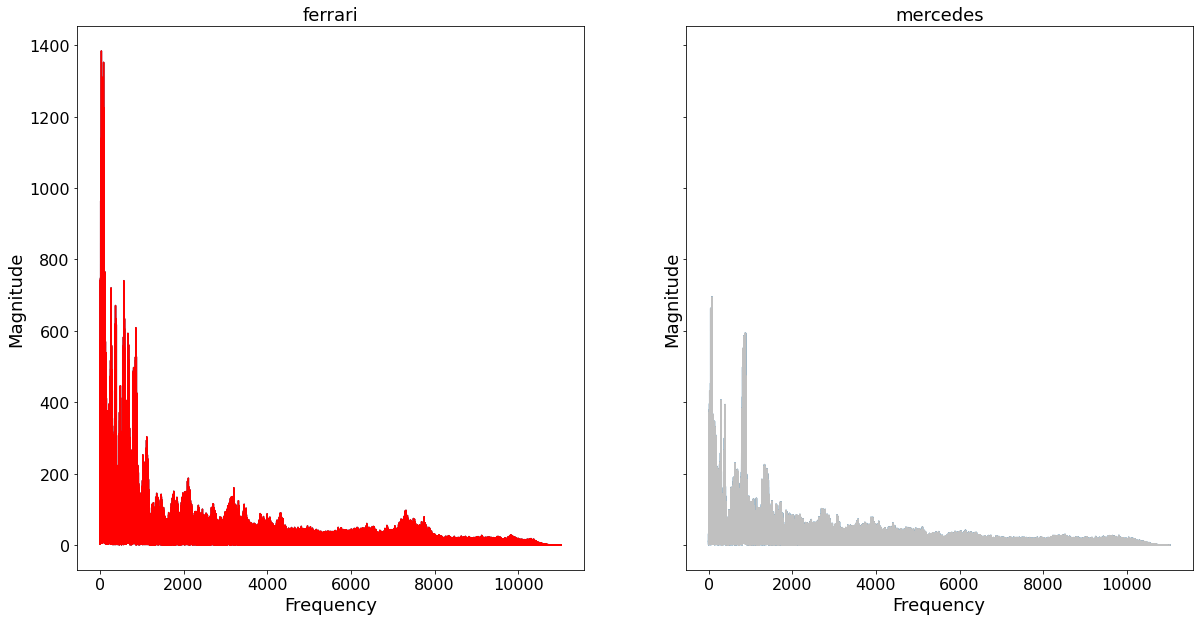

In [106]:
# Fourier Plot
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 10))
axs = axs.ravel()
for num, team in enumerate(dict_examples):
    # Calculating the fourier transform
    signal = dict_examples[team]["signal"]
    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sr, len(magnitude))
    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(frequency)/2)]
# Plotting results
    axs[num].plot(left_frequency, left_magnitude)
    axs[num].set_title(team, {"fontsize":18})
    axs[num].tick_params(axis="both", labelsize=16)
    axs[num].set_ylabel("Magnitude", fontsize=18)
    axs[num].set_xlabel("Frequency", fontsize=18)
    axs[num].plot(left_frequency, left_magnitude,
                  color=dict_examples[team]["color"])
fig.savefig("{}/powerspectrum.png".format(output_path),
            bbox_inches="tight")

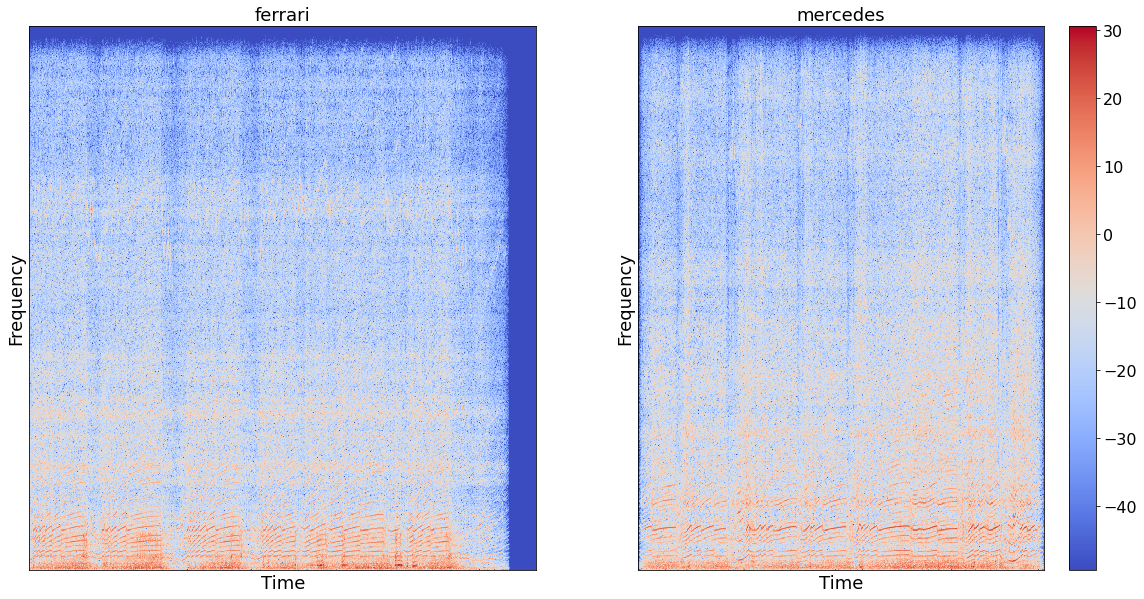

In [107]:
# STFT Plot
n_fft = 2048  # Window for single fourier transform
hop_length = 512  # Amount for shifting to the right
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True,
                        figsize=(20, 10))
axs = axs.ravel()
for num, team in enumerate(dict_examples):
    signal = dict_examples[team]["signal"]
    stft = librosa.core.stft(signal, hop_length=hop_length, 
                             n_fft=n_fft)
    spectogram = np.abs(stft)
    log_spectogram = librosa.amplitude_to_db(spectogram)
    plot = librosa.display.specshow(log_spectogram, sr=sr,
                                    hop_length=hop_length, 
                                    ax=axs[num])
    axs[num].tick_params(axis="both", labelsize=16)
    axs[num].set_title(team, {"fontsize":18})
    axs[num].set_ylabel("Frequency", fontsize=18)
    axs[num].set_xlabel("Time", fontsize=18)
cb = fig.colorbar(plot)
cb.ax.tick_params(labelsize=16)
fig.savefig(r"{}/short_fourier.png".format(output_path),
            bbox_inches="tight")

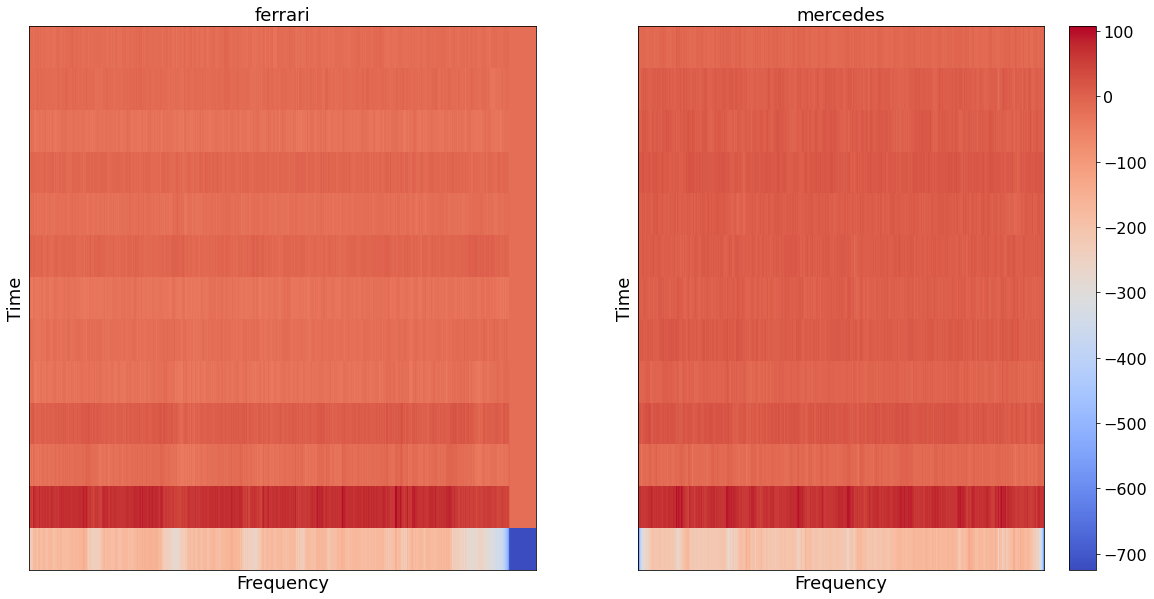

In [108]:
# MFCC Plot
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 10))
axs = axs.ravel()
for num, team in enumerate(dict_examples):
    signal = dict_examples[team]["signal"]
    MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length,
                                 n_mfcc=13)
    plot = librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length,
                                    ax=axs[num])
    axs[num].tick_params(axis="both", labelsize=16)
    axs[num].set_title(team, {"fontsize":18})
    axs[num].set_ylabel("Time", fontsize=18)
    axs[num].set_xlabel("Frequency", fontsize=18)
cb = fig.colorbar(plot)
cb.ax.tick_params(labelsize=16)
fig.savefig(r"{}/mfccs.png".format(output_path),
            bbox_inches="tight")

Start of the Machine learning Part

In [109]:
# Bulk processing packages
from pydub import AudioSegment
from pydub.utils import make_chunks
import math
import re
from tqdm import tqdm
import json
import copy

raw_files = {
    "ferrari": r"{}/ferrari".format(raw_path),
    "mercedes": r"{}/mercedes".format(raw_path)
}

# for team in ["ferrari", "mercedes", "montage"]:
for team in ["ferrari", "mercedes"]:
    wav_files = os.listdir("{}/{}".format(raw_path, team))
    for file in wav_files:
        if not file.startswith("."):
            file_name = "{}/{}/{}".format(raw_path, team, file)
            myaudio = AudioSegment.from_file(file_name, "wav")
            chunk_length_ms = 1000
            chunks = make_chunks(myaudio, chunk_length_ms)
            for i, chunk in enumerate(chunks):
                padding = 3 - len(str(i))
                number = padding*"0" + str(i)
                chunk_name = "{}_{}".format(re.split(".wav", file)[0], number)
                chunk.export("{}/{}/{}.wav".format(data_path, team,
                                                    chunk_name), format="wav")

In [110]:
data = {
     "train": {"mfcc": [], "labels": [], "category": []},
     "test": {"mfcc": [], "labels": [], "category": []},
}
test_tracks = ["f_austria", "m_australia"]
SAMPLE_RATE = 22050
n_mfcc = 13
n_fft = 2048
hop_length = 512
expected_num_mfcc_vectors = math.ceil(SAMPLE_RATE / hop_length)
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):
# ensure that we are not at the root level
    if dirpath is not data_path:
# save the team information
        dirpath_components = dirpath.split("/")
        label = dirpath_components[-1]
# looping over the wav files
        for f in tqdm(filenames):
            if not f.startswith("."):
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
# extract the mfcc from the sound snippet
                mfcc = librosa.feature.mfcc(signal, sr=sr, 
                                            n_fft=n_fft,
                                            n_mfcc=n_mfcc,
                                            hop_length=hop_length)
                mfcc = mfcc.T.tolist()
                # to ensure that all snippets have the same length
                if len(mfcc) == expected_num_mfcc_vectors:
                    if any([track in f for track in test_tracks]):
                        data["test"]["mfcc"].append(mfcc)
                        data["test"]["labels"].append(i-1)
                        data["test"]["category"].append(label)
    #                     elif ("montage" in f):
    #                         print(f)
    #                         data["montage"]["mfcc"].append(mfcc)
                    else:
                        data["train"]["mfcc"].append(mfcc)
                        data["train"]["labels"].append(i-1)
                        data["train"]["category"].append(label)
                        
# saving json with the results
with open("{}/processed_data.json".format(data_path), "w") as fp:
    json.dump(data, fp, indent=4)

 29%|██▊       | 354/1232 [00:35<01:27, 10.02it/s]/home/jupyter-yeokch21/.conda/envs/esd/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1809
  warnings.warn(
 56%|█████▌    | 689/1232 [01:08<00:54,  9.92it/s]/home/jupyter-yeokch21/.conda/envs/esd/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=640
  warnings.warn(
 59%|█████▉    | 732/1232 [01:12<00:49, 10.04it/s]/home/jupyter-yeokch21/.conda/envs/esd/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1610
  warnings.warn(
 87%|████████▋ | 754/870 [01:15<00:11, 10.04it/s]/home/jupyter-yeokch21/.conda/envs/esd/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=993
  warnings.warn(
100%|██████████| 870/870 [01:26<00:00, 10.03it/s]


In [111]:
# Importing packages
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from sklearn.metrics import accuracy_score
# load and convert data
with open("{}/processed_data.json".format(data_path), "r") as fp:
    data = json.load(fp)
       
inputs = np.array(data["train"]["mfcc"])
# inputs = np.array(data["train"])
targets = np.array(data["train"]["labels"])

print(inputs)
print(np.shape(inputs))

# turn data into train and testset
(inputs_train, inputs_test, target_train, target_test) = train_test_split(inputs, targets, test_size=0.2)

[[[-2.59135468e+02  5.00048904e+01 -1.31482143e+01 ... -7.25288820e+00
   -8.86550069e-01  7.00909615e+00]
  [-2.59814209e+02  4.73571472e+01 -1.34405727e+01 ... -1.55881488e+00
    3.66715908e-01  2.66501331e+00]
  [-2.67418274e+02  4.39341125e+01 -7.75612831e+00 ...  8.20465946e+00
    1.69602060e+00 -4.54922390e+00]
  ...
  [-2.40407806e+02  3.26621857e+01 -8.32323551e+00 ...  6.94913268e-02
    3.78013396e+00 -1.00158148e+01]
  [-2.29129181e+02  5.21076660e+01 -6.67584419e+00 ... -1.56951272e+00
    6.20342016e-01 -1.09907894e+01]
  [-2.16889221e+02  6.67331543e+01 -5.58303881e+00 ... -5.03340149e+00
   -1.26030302e+00 -1.34884682e+01]]

 [[-6.52588806e+01  4.96812134e+01 -2.02236900e+01 ...  4.94040012e+00
    4.42241848e-01 -1.17758369e+01]
  [-6.18575134e+01  4.35027390e+01 -2.58617783e+01 ...  4.20488262e+00
    3.79918957e+00 -9.22609043e+00]
  [-6.77483444e+01  4.21654434e+01 -2.77700062e+01 ...  4.76438046e+00
    5.59497118e+00 -9.48615551e+00]
  ...
  [-7.28300552e+01  4.5

In [133]:

# build the network architecture
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(inputs.shape[1],
                                      inputs.shape[2])),
# 1st hidden layer
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.3),
# 2nd hidden layer
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.3),
# 3rd hidden layer
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
# output layer
    keras.layers.Dense(1, activation="sigmoid")
])
# compiling the network
optimizer = keras.optimizers.Adam(learning_rate=0.000_1)
model.compile(optimizer=optimizer, loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()
# train the network
history = model.fit(inputs_train, target_train,
                    validation_data=(inputs_test, target_test),
                    epochs=100,
                    batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 572)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               293376    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

Epoch 49/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.9438 - val_loss: 0.1198 - val_accuracy: 0.9501
Epoch 50/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.9424 - val_loss: 0.1071 - val_accuracy: 0.9501
Epoch 51/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1948 - accuracy: 0.9368 - val_loss: 0.1041 - val_accuracy: 0.9474
Epoch 52/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1856 - accuracy: 0.9451 - val_loss: 0.1217 - val_accuracy: 0.9474
Epoch 53/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9507 - val_loss: 0.1074 - val_accuracy: 0.9501
Epoch 54/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9444 - val_loss: 0.1070 - val_accuracy: 0.9501
Epoch 55/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.9514 - val_loss: 0.1152 - val_accuracy: 0.9501
Epoch 

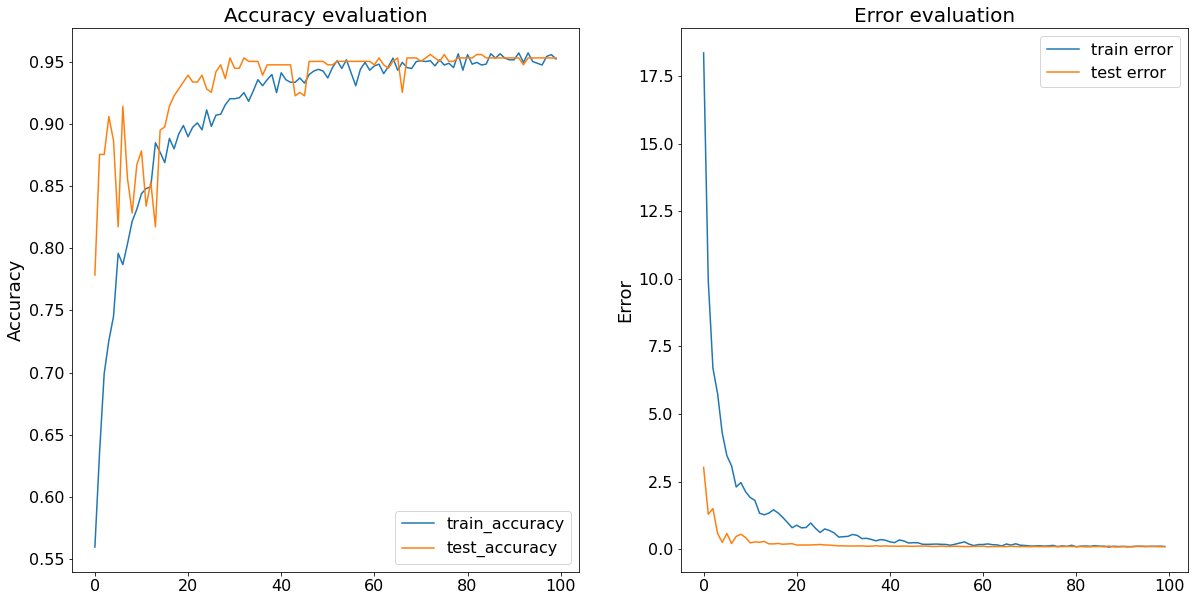

In [134]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# create accuracy subplot
axs[0].plot(history.history["accuracy"], label="train_accuracy")
axs[0].plot(history.history["val_accuracy"], label="test_accuracy")
axs[0].set_ylabel("Accuracy", fontsize=18)
axs[0].legend(loc="lower right", prop={"size": 16})
axs[0].set_title("Accuracy evaluation", fontsize=20)
axs[0].tick_params(axis="both", labelsize=16)
# create error subplot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error", fontsize=18)
axs[1].legend(loc="upper right", prop={"size": 16})
axs[1].set_title("Error evaluation", fontsize=20)
axs[1].tick_params(axis="both", labelsize=16)
fig.savefig("{}/accuracy_error.png".format(output_path),
            bbox_inches="tight")
plt.show()

In [147]:
test_inputs = np.array(data["test"]["mfcc"])
test_targets = np.array(data["test"]["labels"])
# predictions = model.predict_classes(test_inputs)

predictions = model.predict(test_inputs)
predictions = np.round(predictions).astype(int)

acc = accuracy_score(test_targets, predictions)
print(acc)

0.9717314487632509
